# Fitting Gaussian Process Models in Python

## Building models with Gaussians

In [28]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

A Gaussian Process (GP) is fully specified by a mean function and a covariance function.

$$ p(x) \sim \mathcal{GP}(m(x), k(x,x')) $$

One possible specification is:

$$ 
\begin{align*} 
    m(x) &= 0 \\
    k(x, x') &= \theta_1\exp{\left(-\frac{\theta_2}{2}(x-x')^2\right)}
\end{align*} 
$$

In [5]:
def exponential_cov(x, y, params):
    return params[0] * np.exp(-0.5 * params[1] * np.power(np.subtract.outer(x,y), 2))

Using the conditional property of multivariate Gaussian distributions, we can generate realizations sequentially, point by point.

$$ p(x|y) = \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y),
\Sigma_x-\Sigma{xy}\Sigma_y^{-1}\Sigma{xy}^T) $$

In [6]:
def conditional(x_new, x, y, params):
    B = exponential_cov(x_new, x, params)
    C = exponential_cov(x, x, params)
    A = exponential_cov(x_new, x_new, params)
    mu = np.linalg.inv(C).dot(B.T).T.dot(y)
    sigma = A - B.dot(np.linalg.inv(C).dot(B.T))
    return mu.squeeze(), sigma.squeeze()

Start with a GP prior with hyperparameters $\sigma_0=1,\sigma_1=10.$

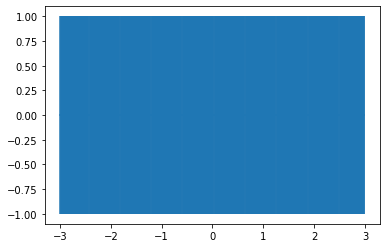

In [7]:
theta = [1, 10]
sigma_0 = exponential_cov(0, 0, theta)
xpts = np.arange(-3, 3, step=0.01)
plt.errorbar(xpts, np.zeros(len(xpts)), yerr=sigma_0, capsize=0)
plt.show()

Select an arbitrary starting point to sample, say $x=1$. With no previous points, we can sample from an unconditional Gaussian.

In [8]:
x = [1.]
y = [np.random.normal(scale=sigma_0)]
print(y)

[0.11319963311945165]


We can now update our confidence band, given the point that we just sampled, using the covariance function to generate new point-wise intervals, conditional on the value $(x_0, y_0)$.

In [9]:
def predict(x, data, kernel, params, sigma, t):
    k = [kernel(x, y, params) for y in data]
    Sinv = np.linalg.inv(sigma)
    y_pred = np.dot(k, Sinv).dot(t)
    sigma_new = kernel(x, y, params) - np.dot(k, Sinv).dot(k)
    return y_pred, sigma_new.item()

sigma_1 = exponential_cov(x, x, theta)
x_pred = np.linspace(-3, 3, 1000)
predictions = [predict(i, x, exponential_cov, theta, sigma_1, y) for i in x_pred]

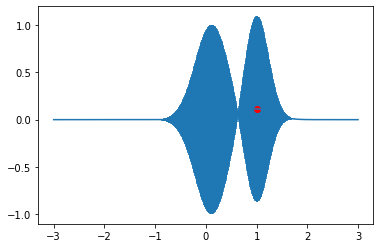

In [10]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, 'ro')
plt.show()

Sample another point.

In [11]:
m, s = conditional([-0.7], x, y, theta)
y2 = np.random.normal(m, s)
print(y2)

-0.2262095884953349


Add the point to the realization and update the location for the next point.

In [12]:
x.append(-0.7)
y.append(y2)
sigma_2 = exponential_cov(x, x, theta)
predictions = [predict(i, x, exponential_cov, theta, sigma_2, y) for i in x_pred]

ValueError: can only convert an array of size 1 to a Python scalar

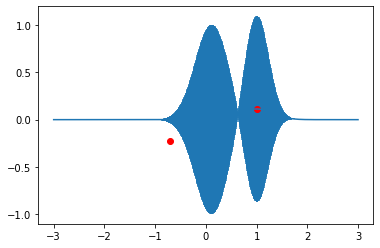

In [13]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, 'ro')
plt.show()

# Fitting Gaussian Processes in Python

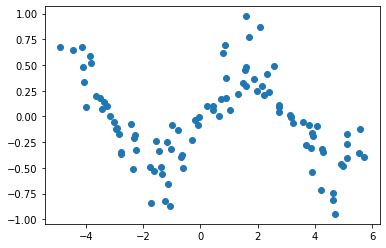

In [39]:
X = np.linspace(-5, 5, 100)
noise = np.random.rand(*X.shape)
X += noise

Y = np.sin(X)
noise = np.random.rand(*Y.shape)
Y *= noise

plt.scatter(X, Y)
plt.show()

## scikit-learn

In [1]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

In [46]:
dir(gaussian_process)

['GaussianProcessClassifier',
 'GaussianProcessRegressor',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_gpc',
 '_gpr',
 'kernels']

In [2]:
kernel = ConstantKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1)

In [44]:
X = X.reshape(-1, 1)
y = Y.reshape(-1, 1)

In [48]:
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(X, y)

/home/jason/miniconda3/envs/gp_p38/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1))

# GPflow

In [51]:
import gpflow
k = gpflow.kernels.Matern32(1, variance=1, lengthscale=1.2)
m = gpflow.gpr.GPR(X, Y, kern=k)

2022-08-17 21:23:41.879583: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-17 21:23:41.879682: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TypeError: __init__() got multiple values for argument 'variance'